# Loading necessary modules

In [0]:
#!pip install -Iv tensorflow

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import cv2
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

%system nvidia-smi
#%system rocm-smi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


py 3.6.9
tf 2.2.0-rc2
keras 2.3.0-tf
mem 13021.05078125
cpu 2


['Mon Apr  6 04:49:13 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

#Get Img Data 

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!ls -an "/gdrive/My Drive/Python/ObjectDetection/TL/data"

total 2200
-rw------- 1 0 0 1220620 Apr  5 13:18 1_2020-03-29_DK1LE3ZlZyI.pkl
-rw------- 1 0 0  111035 Apr  5 13:18 1_2020-03-29_fdqOdTvGc9I.pkl
-rw------- 1 0 0    8607 Apr  5 13:18 12020-03-29_LB6McOGIolY.pkl
-rw------- 1 0 0   10989 Apr  5 13:18 2020-03-25_TuI0uW7nsSw.pkl
-rw------- 1 0 0  235562 Apr  5 13:18 2020-03-28_fdqOdTvGc9I.pkl
-rw------- 1 0 0   20570 Apr  5 05:02 2020-03-28_nhNRbb8MSBQ.pkl
-rw------- 1 0 0   64684 Apr  5 05:02 2020-03-29_1_6G5-PMk_jjw.pkl
-rw------- 1 0 0  104885 Apr  5 05:02 2020-03-29_6G5-PMk_jjw.pkl
-rw------- 1 0 0  212901 Apr  5 05:02 2020-03-29_nhNRbb8MSBQ.pkl
-rw------- 1 0 0   12282 Apr  5 05:02 2020-03-30_2xr-s27dPJE.pkl
-rw------- 1 0 0   21959 Apr  5 05:02 2020-03-30_6G5-PMk_jjw.pkl
-rw------- 1 0 0   30945 Apr  5 05:02 2020-03-30_fdqOdTvGc9I.pkl
-rw------- 1 0 0   52656 Apr  5 05:03 2020-03-30_QPuPxNyujXw.pkl
-rw------- 1 0 0  109690 Apr  5 13:18 2020-03-31_NRONUthxaQE.pkl
-rw------- 1 0 0   13413 Apr  5 13:18 2020-03-31_QPuPxNyujXw.pkl
-rw----

#Variables

In [0]:
batch_size = 32
testsplit = .1
targetx = 96#224
targety = 96#224
learning_rate = 0.0001
classes = 1
seed = 43

app_dir= "/gdrive/My Drive/Python/ObjectDetection/TL/"
data_dir = "/gdrive/My Drive/Python/ObjectDetection/TL/data/"

#Image data read

In [5]:
def loadpkl(filename):
      with open(filename, 'rb') as f:
          data = pickle.load(f)
          x=np.array([cv2.cvtColor(cv2.resize(d[1], (targetx, targety)), cv2.COLOR_BGR2RGB) for d in data])
          y=np.array([d[0] for d in data])
      return x,y
X=None
Y=None
for filename in os.listdir(data_dir):
    if filename.endswith(".pkl"): 
         print(os.path.join(data_dir, filename))
         if X is None:
           X,Y=loadpkl(os.path.join(data_dir, filename))
         else:
           x,y=loadpkl(os.path.join(data_dir, filename))
           X=np.append(X,x, axis=0)
           Y=np.append(Y,y)
X.shape

/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-30_2xr-s27dPJE.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-30_fdqOdTvGc9I.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-30_6G5-PMk_jjw.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-29_6G5-PMk_jjw.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-28_nhNRbb8MSBQ.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-29_1_6G5-PMk_jjw.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-29_nhNRbb8MSBQ.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-30_QPuPxNyujXw.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-04-01_lLogKtUR0Xo.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-31_QPuPxNyujXw.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-31_NRONUthxaQE.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/12020-03-29_LB6McOGIolY.pkl
/gdrive/My Drive/Python/ObjectDetection/TL/data/2020-03-25_TuI0uW7nsSw.pkl
/gdrive/My Drive/Pytho

(1902, 96, 96, 3)

#Keras data generator

In [0]:
datagen = ImageDataGenerator(
        #shear_range=0.1,
        data_format = "channels_last",
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)
#datagen.fit(X)
train_generator = datagen.flow(
        X,Y,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow(
        X,Y,
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        subset="validation"
)

#Sample image

[1 0 1 0 1]


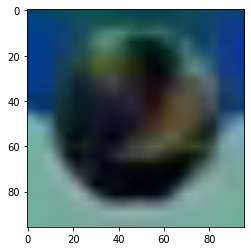

In [7]:
print(Y[:5])
img=Image.fromarray(X[1142]) 
plt.imshow(img)

#Keras callbacks

In [0]:
checkpoint = ModelCheckpoint(os.path.join(app_dir, 'ball_classifier_sigmoid_96.h5'),
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq='epoch')

#https://github.com/keras-team/keras/issues/3358
tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            #batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=15,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=None,#epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#Define new top layers and compile model

In [9]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
## x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
#x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = Dense(16, activation='relu')(x)
#x = Dense(8, activation='relu')(x)
#x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='sigmoid')(x) #, kernel_initializer='random_uniform', bias_initializer='zeros'

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=learning_rate)
#optimizer = RMSprop(lr=learning_rate)

loss = tf.keras.losses.BinaryCrossentropy()#from_logits=True
#"categorical_crossentropy"
# loss = "kullback_leibler_divergence"

# for layer in model.layers:
#     layer.trainable = True


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

#model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

9412608/9406464 [==============================] - 0s 0us/step


#Fit model

In [11]:
%%time

params = model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=100,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6513
Epoch 00001: val_accuracy improved from -inf to 0.56842, saving model to /gdrive/My Drive/Python/ObjectDetection/TL/ball_classifier_sigmoid_96.h5
54/54 [==============================] - 3s 55ms/step - loss: 0.6502 - accuracy: 0.6513 - val_loss: 0.7127 - val_accuracy: 0.5684 - lr: 1.0000e-04
Epoch 2/100
52/54 [===========================>..] - ETA: 0s - loss: 0.4872 - accuracy: 0.7668
Epoch 00002: val_accuracy improved from 0.56842 to 0.65263, saving model to /gdrive/My Drive/Python/ObjectDetection/TL/ball_classifier_sigmoid_96.h5
54/54 [==============================] - 2s 35ms/step - loss: 0.4841 - accuracy: 0.7699 - val_loss: 0.6413 - val_accuracy: 0.6526 - lr: 1.0000e-04
Epoch 3/100
53/54 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8149
Epoch 00003: val_accuracy improved from 0.65263 to 0.70526, saving model to /gdrive/My Drive/Python/ObjectDetection/TL/ball_cl

#Unfreeze and fine tuning

In [13]:
for layer in model.layers:
    layer.trainable = True
params1 = model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=100,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])
#model.summary()

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9334
Epoch 00001: val_accuracy did not improve from 0.84211
54/54 [==============================] - 2s 29ms/step - loss: 0.1822 - accuracy: 0.9334 - val_loss: 0.4150 - val_accuracy: 0.8105 - lr: 1.0000e-06
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9282
Epoch 00002: val_accuracy did not improve from 0.84211
54/54 [==============================] - 1s 26ms/step - loss: 0.1904 - accuracy: 0.9282 - val_loss: 0.4363 - val_accuracy: 0.8053 - lr: 1.0000e-06
Epoch 3/100
53/54 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9280
Epoch 00003: val_accuracy did not improve from 0.84211
54/54 [==============================] - 1s 27ms/step - loss: 0.1917 - accuracy: 0.9282 - val_loss: 0.4121 - val_accuracy: 0.8105 - lr: 1.0000e-06
Epoch 4/100
53/54 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9262
Epoch 00004: v

#Training and test loss/accuracy graphs


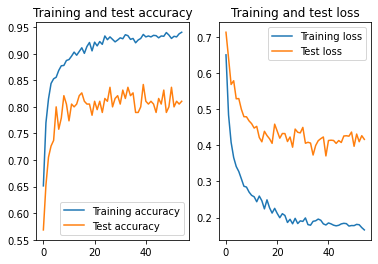

In [14]:
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

#Example calculate predictions

[[0.64165026]
 [0.32078376]
 [0.36611882]
 [0.00557879]
 [0.5802527 ]
 [0.00748405]
 [0.63934577]
 [0.06406618]
 [0.5423206 ]
 [0.01133267]
 [0.92514706]]


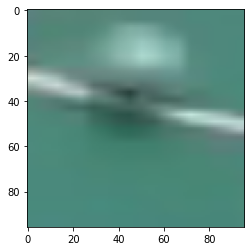

In [17]:
import math
img=Image.fromarray(X[226])#.resize((targetx, targety))
plt.imshow(img)
probabilities = model.predict(preprocess_input(X[220:231]))
#print(1 / (1 + math.exp(-1*probabilities)))
print((probabilities))

#Todo classifications report

In [0]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))

# y = 1*(predictions>0)
# Y.shape
# # print('Classification Report')
# # cr = classification_report(y_true=np.expand_dims(Y,axis=1), y_pred=y)
# # print(cr)